# Pajala ARV Flöden
Data leverarad av Kristofer Grammer <kristofer.gramner@gefasystem.se>. Data bearbetat och diagram skapade av Christian Nilsson med hjälp av Github Copilot.

In [1]:
# .\.venv\Scripts\Activate.ps1

In [2]:
import inspect
import re
import json
from pathlib import Path
import pandas as pd
def dprint(x): # https://stackoverflow.com/questions/32000934/print-a-variables-name-and-value/57225950#57225950
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} = {}".format(r,x))

def _pk1_path_for_file(file_path):
    """Return Path for .pk1 cache file stored next to the input file with same base name and extension '.pk1'."""
    p = Path(file_path) if not isinstance(file_path, Path) else file_path
    return p.with_suffix('.pk1')

def load_or_cache_excel(xlsx_path, read_kwargs=None, force_refresh=False):
    """Load DataFrame from a .pk1 cache next to the xlsx if present; otherwise read the xlsx and save the .pk1.
    Returns the DataFrame.
    read_kwargs: dict forwarded to pd.read_excel.
    force_refresh: if True, re-read the Excel and overwrite cache."""
    read_kwargs = read_kwargs or {}
    pk1 = _pk1_path_for_file(xlsx_path)
    if pk1.exists() and not force_refresh:
        try:
            df = pd.read_pickle(pk1)
            print(f'Loaded cache {pk1}')
            return df
        except Exception as e:
            print(f'Warning: failed to load {pk1} (will re-read Excel): {e}')
    # read Excel and attempt to save cache
    df = pd.read_excel(xlsx_path, **read_kwargs)
    try:
        df.to_pickle(pk1)
        print(f'Saved cache {pk1}')
    except Exception as e:
        print(f'Warning: could not save cache {pk1}: {e}')
    return df

def load_or_cache_csv(csv_path, read_kwargs=None, force_refresh=False):
    """Load DataFrame from a .pk1 cache next to the csv if present; otherwise read the csv and save the .pk1.
    Returns the DataFrame.
    read_kwargs: dict forwarded to pd.read_csv.
    force_refresh: if True, re-read the CSV and overwrite cache."""
    read_kwargs = read_kwargs or {}
    # Set default read parameters for our specific CSV format
    default_params = {
        'sep': ';',  # semicolon separated
        'decimal': ',',  # comma as decimal separator
        'parse_dates': ['TimeDate'],  # parse TimeDate column as datetime
    }
    # Update with any user-provided parameters
    read_kwargs = {**default_params, **read_kwargs}
    
    pk1 = _pk1_path_for_file(csv_path)
    if pk1.exists() and not force_refresh:
        try:
            df = pd.read_pickle(pk1)
            print(f'Loaded cache {pk1}')
            return df
        except Exception as e:
            print(f'Warning: failed to load {pk1} (will re-read CSV): {e}')
    # read CSV and attempt to save cache
    df = pd.read_csv(csv_path, **read_kwargs)
    try:
        df.to_pickle(pk1)
        print(f'Saved cache {pk1}')
    except Exception as e:
        print(f'Warning: could not save cache {pk1}: {e}')
    return df

In [3]:
# Read CSV files (with pk1 cache next to each csv). Uses load_or_cache_csv from previous cell.
csv_file_path_FT10101 = r'c:\Users\chrini\OneDrive - Norconsult Group\Projekt\1097224_Pajala ARV\4 Underlag\Mejl\20251104_1609_Re_ Malmberg Water i Yngsjö - ARV Pajala, åtgärd diverse styrpunkter_Kristofer Gramner\20251104\FT10101.csv'
csv_file_path_FT30101 = r'c:\Users\chrini\OneDrive - Norconsult Group\Projekt\1097224_Pajala ARV\4 Underlag\Mejl\20251104_1609_Re_ Malmberg Water i Yngsjö - ARV Pajala, åtgärd diverse styrpunkter_Kristofer Gramner\20251104\FT30101.csv'
csv_file_path_FT72101 = r'c:\Users\chrini\OneDrive - Norconsult Group\Projekt\1097224_Pajala ARV\4 Underlag\Mejl\20251104_1609_Re_ Malmberg Water i Yngsjö - ARV Pajala, åtgärd diverse styrpunkter_Kristofer Gramner\20251104\FT72101.csv'
csv_file_path_FT80101 = r'c:\Users\chrini\OneDrive - Norconsult Group\Projekt\1097224_Pajala ARV\4 Underlag\Mejl\20251104_1609_Re_ Malmberg Water i Yngsjö - ARV Pajala, åtgärd diverse styrpunkter_Kristofer Gramner\20251104\FT80101.csv'
csv_file_path_LT23101 = r'c:\Users\chrini\OneDrive - Norconsult Group\Projekt\1097224_Pajala ARV\4 Underlag\Mejl\20251104_1609_Re_ Malmberg Water i Yngsjö - ARV Pajala, åtgärd diverse styrpunkter_Kristofer Gramner\20251104\LT23101.csv'

# Load using the helper which places the .pk1 next to the csv with same base name
df_Inflöde_FT10101 = load_or_cache_csv(csv_file_path_FT10101) #Inflöde
df_Utflöde_FT72101 = load_or_cache_csv(csv_file_path_FT72101) #Utflöde
df_MBBRflöde_FT30101 = load_or_cache_csv(csv_file_path_FT30101) #MBBR-flöde
df_Inflöde_Extenslam_FT80101 = load_or_cache_csv(csv_file_path_FT80101) #Inflöde Extenslam
df_Nivå_Bräddning_LT23101 = load_or_cache_csv(csv_file_path_LT23101) #Utflöde Bräddning


Loaded cache c:\Users\chrini\OneDrive - Norconsult Group\Projekt\1097224_Pajala ARV\4 Underlag\Mejl\20251104_1609_Re_ Malmberg Water i Yngsjö - ARV Pajala, åtgärd diverse styrpunkter_Kristofer Gramner\20251104\FT10101.pk1
Loaded cache c:\Users\chrini\OneDrive - Norconsult Group\Projekt\1097224_Pajala ARV\4 Underlag\Mejl\20251104_1609_Re_ Malmberg Water i Yngsjö - ARV Pajala, åtgärd diverse styrpunkter_Kristofer Gramner\20251104\FT72101.pk1
Loaded cache c:\Users\chrini\OneDrive - Norconsult Group\Projekt\1097224_Pajala ARV\4 Underlag\Mejl\20251104_1609_Re_ Malmberg Water i Yngsjö - ARV Pajala, åtgärd diverse styrpunkter_Kristofer Gramner\20251104\FT30101.pk1
Loaded cache c:\Users\chrini\OneDrive - Norconsult Group\Projekt\1097224_Pajala ARV\4 Underlag\Mejl\20251104_1609_Re_ Malmberg Water i Yngsjö - ARV Pajala, åtgärd diverse styrpunkter_Kristofer Gramner\20251104\FT80101.pk1
Loaded cache c:\Users\chrini\OneDrive - Norconsult Group\Projekt\1097224_Pajala ARV\4 Underlag\Mejl\20251104_160

In [4]:
# dprint(df_1.head())
df_Inflöde_FT10101.rename(columns={'TimeDate': 'DateTime', 'Val':'Inflöde FT-10101'}, inplace=True)
df_Inflöde_FT10101['DateTime'] = pd.to_datetime(df_Inflöde_FT10101['DateTime'])
df_Inflöde_FT10101.drop(columns=['ID', 'TimeLength'], inplace=True)
df_Inflöde_FT10101.set_index('DateTime', inplace=True)
# dprint(df_1.head())


# print(df_2.head())
df_Utflöde_FT72101.rename(columns={'TimeDate': 'DateTime', 'Val':'Utflöde FT-72101'}, inplace=True)
df_Utflöde_FT72101['DateTime'] = pd.to_datetime(df_Utflöde_FT72101['DateTime'])
df_Utflöde_FT72101.drop(columns=['ID', 'TimeLength'], inplace=True)
df_Utflöde_FT72101.set_index('DateTime', inplace=True)
dprint(df_Utflöde_FT72101.head())

df_Inflöde_Extenslam_FT80101.rename(columns={'TimeDate': 'DateTime', 'Val':'Inflöde Extenslam FT80101'}, inplace=True)
df_Inflöde_Extenslam_FT80101['DateTime'] = pd.to_datetime(df_Inflöde_Extenslam_FT80101['DateTime'])
df_Inflöde_Extenslam_FT80101.drop(columns=['ID', 'TimeLength'], inplace=True)
df_Inflöde_Extenslam_FT80101.set_index('DateTime', inplace=True)
dprint(df_Inflöde_Extenslam_FT80101.head())
df_Inflöde_Extenslam_FT80101_before_zeroflow_calib = df_Inflöde_Extenslam_FT80101
df_Inflöde_Extenslam_FT80101['Inflöde Extenslam FT80101'] = df_Inflöde_Extenslam_FT80101['Inflöde Extenslam FT80101'] + 0.486474692821503

df_Nivå_Bräddning_LT23101.rename(columns={'TimeDate': 'DateTime', 'Val':'Nivå Bräddning LT23101'}, inplace=True)
df_Nivå_Bräddning_LT23101['DateTime'] = pd.to_datetime(df_Nivå_Bräddning_LT23101['DateTime'])
df_Nivå_Bräddning_LT23101.drop(columns=['ID', 'TimeLength'], inplace=True)
df_Nivå_Bräddning_LT23101.set_index('DateTime', inplace=True)
dprint(df_Nivå_Bräddning_LT23101.head())

df_MBBRflöde_FT30101.rename(columns={'TimeDate': 'DateTime', 'Val':'MBBRflöde FT30101'}, inplace=True)
df_MBBRflöde_FT30101['DateTime'] = pd.to_datetime(df_MBBRflöde_FT30101['DateTime'])
df_MBBRflöde_FT30101.drop(columns=['ID', 'TimeLength'], inplace=True)
df_MBBRflöde_FT30101.set_index('DateTime', inplace=True)
dprint(df_MBBRflöde_FT30101.head())

# Merge the DataFrames on the DateTime index, aligning values
# Using merge instead of concat to handle any duplicate indices
# Merge all DataFrames sequentially
df_ax = pd.merge(df_Inflöde_FT10101, df_Utflöde_FT72101, left_index=True, right_index=True, how='outer')
df_ax = pd.merge(df_ax, df_Inflöde_Extenslam_FT80101, left_index=True, right_index=True, how='outer')
df_ax = pd.merge(df_ax, df_MBBRflöde_FT30101, left_index=True, right_index=True, how='outer')

# Show the result
print("\nMerged DataFrame:")
dprint(df_ax.head())

# Check for any missing values after merge
print("\nMissing values in merged DataFrame:")
dprint(df_ax.isna().sum())


df_Utflöde_FT72101.head() =                      Utflöde FT-72101
DateTime                             
2024-11-01 03:01:00         71.990110
2024-11-01 03:02:00         37.916668
2024-11-01 03:03:00         17.846454
2024-11-01 03:04:00         11.633287
2024-11-01 03:05:00         45.686008
df_Inflöde_Extenslam_FT80101.head() =                      Inflöde Extenslam FT80101
DateTime                                      
2024-11-01 03:01:00                  -0.486475
2024-11-01 03:02:00                  -0.486475
2024-11-01 03:03:00                  -0.486475
2024-11-01 03:04:00                  -0.486475
2024-11-01 03:05:00                  -0.486475
df_Nivå_Bräddning_LT23101.head() =                      Nivå Bräddning LT23101
DateTime                                   
2024-11-01 03:01:00                0.148113
2024-11-01 03:02:00                0.148113
2024-11-01 03:03:00                0.148113
2024-11-01 03:04:00                0.148113
2024-11-01 03:05:00                0.148

In [5]:
# Show all column names to verify what needs renaming
print("Columns in df_Inflöde_FT10101:", df_Inflöde_FT10101.columns.tolist())
print("Columns in df_Utflöde_FT72101:", df_Utflöde_FT72101.columns.tolist())
print("Columns in df_ax:", df_ax.columns.tolist())

Columns in df_Inflöde_FT10101: ['Inflöde FT-10101']
Columns in df_Utflöde_FT72101: ['Utflöde FT-72101']
Columns in df_ax: ['Inflöde FT-10101', 'Utflöde FT-72101', 'Inflöde Extenslam FT80101', 'MBBRflöde FT30101']


In [6]:
# Show DateTime indices where there are missing values
print("\nDateTime indices with missing FT-10101:")
print(df_ax[df_ax['Inflöde FT-10101'].isna()].index.strftime('%Y-%m-%d %H:%M:%S').tolist())

print("\nDateTime indices with missing FT-72101:")
print(df_ax[df_ax['Utflöde FT-72101'].isna()].index.strftime('%Y-%m-%d %H:%M:%S').tolist())

# Print summary of gaps
print("\nSummary of gaps:")
print(f"Total rows in merged DataFrame: {len(df_ax)}")
print(f"Rows with missing FT-10101: {df_ax['Inflöde FT-10101'].isna().sum()}")
print(f"Rows with missing FT-72101: {df_ax['Utflöde FT-72101'].isna().sum()}")
print(f"Rows with data in both columns: {len(df_ax) - df_ax.isna().any(axis=1).sum()}")


DateTime indices with missing FT-10101:
['2025-11-04 15:44:00', '2025-11-04 15:45:00', '2025-11-04 15:46:00', '2025-11-04 15:47:00', '2025-11-04 15:48:00', '2025-11-04 15:49:00', '2025-11-04 15:50:00']

DateTime indices with missing FT-72101:
['2025-11-04 15:50:00']

Summary of gaps:
Total rows in merged DataFrame: 513892
Rows with missing FT-10101: 7
Rows with missing FT-72101: 1
Rows with data in both columns: 513885


# Check and Remove Duplicate Timestamps
Before calculating moving averages, we need to identify and remove any duplicate timestamps from the source data.

In [7]:
# Collect all duplicate timestamps before removing them
df_duplicate_timestamps = pd.DataFrame()

# Helper function to collect duplicates from a DataFrame
def collect_duplicates(df, df_name):
    """Collect duplicate rows and return them with a source column."""
    if df.index.duplicated().any():
        dup_mask = df.index.duplicated(keep=False)  # Mark ALL duplicates, not just subsequent ones
        dup_rows = df[dup_mask].copy()
        dup_rows['Source'] = df_name
        dup_rows['DuplicateGroup'] = dup_rows.index.astype(str)
        return dup_rows
    return pd.DataFrame()

# Check for and collect duplicate indices before removal
frames_to_check = {
    'df_ax': df_ax,
    'df_Inflöde_Extenslam_FT80101': df_Inflöde_Extenslam_FT80101,
    'df_Nivå_Bräddning_LT23101': df_Nivå_Bräddning_LT23101,
    'df_MBBRflöde_FT30101': df_MBBRflöde_FT30101
}

duplicate_collections = []
for name, df_frame in frames_to_check.items():
    if df_frame.index.duplicated().any():
        dup_count = df_frame.index.duplicated().sum()
        print(f"Warning: {name} has {dup_count} duplicate indices. Keeping first occurrence.")
        
        # Collect duplicates
        dup_df = collect_duplicates(df_frame, name)
        if not dup_df.empty:
            duplicate_collections.append(dup_df)
        
        # Remove duplicates from the original frame
        if name == 'df_ax':
            df_ax = df_ax[~df_ax.index.duplicated(keep='first')]
        elif name == 'df_Inflöde_Extenslam_FT80101':
            df_Inflöde_Extenslam_FT80101 = df_Inflöde_Extenslam_FT80101[~df_Inflöde_Extenslam_FT80101.index.duplicated(keep='first')]
        elif name == 'df_Nivå_Bräddning_LT23101':
            df_Nivå_Bräddning_LT23101 = df_Nivå_Bräddning_LT23101[~df_Nivå_Bräddning_LT23101.index.duplicated(keep='first')]
        elif name == 'df_MBBRflöde_FT30101':
            df_MBBRflöde_FT30101 = df_MBBRflöde_FT30101[~df_MBBRflöde_FT30101.index.duplicated(keep='first')]

# Combine all duplicate collections into one DataFrame
if duplicate_collections:
    df_duplicate_timestamps = pd.concat(duplicate_collections, axis=0)
    df_duplicate_timestamps = df_duplicate_timestamps.sort_values(['DuplicateGroup', 'Source'])
    print(f"\nTotal duplicate rows collected: {len(df_duplicate_timestamps)}")
    print(f"Unique duplicate timestamps: {df_duplicate_timestamps.index.nunique()}")
    
    # Save to CSV
    csv_path = 'duplicate_timestamps.csv'
    df_duplicate_timestamps.to_csv(csv_path)
    print(f"Duplicate timestamps saved to: {csv_path}")
else:
    print("\nNo duplicates found in any DataFrame.")

print(f"\nCleaned DataFrame sizes:")
print(f"  df_ax: {len(df_ax)} rows")
print(f"  df_Inflöde_Extenslam_FT80101: {len(df_Inflöde_Extenslam_FT80101)} rows")
print(f"  df_Nivå_Bräddning_LT23101: {len(df_Nivå_Bräddning_LT23101)} rows")
print(f"  df_MBBRflöde_FT30101: {len(df_MBBRflöde_FT30101)} rows")


Total duplicate rows collected: 22
Unique duplicate timestamps: 1
Duplicate timestamps saved to: duplicate_timestamps.csv

Cleaned DataFrame sizes:
  df_ax: 513877 rows
  df_Inflöde_Extenslam_FT80101: 513877 rows
  df_Nivå_Bräddning_LT23101: 513892 rows
  df_MBBRflöde_FT30101: 513874 rows

Total duplicate rows collected: 22
Unique duplicate timestamps: 1
Duplicate timestamps saved to: duplicate_timestamps.csv

Cleaned DataFrame sizes:
  df_ax: 513877 rows
  df_Inflöde_Extenslam_FT80101: 513877 rows
  df_Nivå_Bräddning_LT23101: 513892 rows
  df_MBBRflöde_FT30101: 513874 rows


In [8]:
# Summary of duplicate timestamps
if not df_duplicate_timestamps.empty:
    print("=" * 60)
    print("DUPLICATE TIMESTAMPS SUMMARY")
    print("=" * 60)
    print(f"Total duplicate rows captured: {len(df_duplicate_timestamps)}")
    print(f"Number of unique duplicate timestamps: {df_duplicate_timestamps.index.nunique()}")
    
    print("\nDuplicates by source DataFrame:")
    source_counts = df_duplicate_timestamps.groupby('Source').size()
    for source, count in source_counts.items():
        print(f"  {source}: {count} rows")
    
    print("\nUnique timestamps that appear multiple times:")
    unique_dups = sorted(df_duplicate_timestamps.index.unique())
    for ts in unique_dups:
        print(f"  {ts.strftime('%Y-%m-%d %H:%M:%S')}")
    
    # Show a sample of the data for one duplicate timestamp
    print("\nExample: Data for first duplicate timestamp")
    first_dup = unique_dups[0]
    sample = df_duplicate_timestamps[df_duplicate_timestamps.index == first_dup]
    print(sample.to_string())
    
    # Optionally save to CSV
    csv_path = 'duplicate_timestamps.csv'
    df_duplicate_timestamps.to_csv(csv_path)
    print(f"\nDuplicate timestamps saved to: {csv_path}")


DUPLICATE TIMESTAMPS SUMMARY
Total duplicate rows captured: 22
Number of unique duplicate timestamps: 1

Duplicates by source DataFrame:
  df_Inflöde_Extenslam_FT80101: 2 rows
  df_MBBRflöde_FT30101: 2 rows
  df_Nivå_Bräddning_LT23101: 2 rows
  df_ax: 16 rows

Unique timestamps that appear multiple times:
  2025-07-07 07:47:00

Example: Data for first duplicate timestamp
                     Inflöde FT-10101  Utflöde FT-72101  Inflöde Extenslam FT80101  MBBRflöde FT30101                        Source       DuplicateGroup  Nivå Bräddning LT23101
DateTime                                                                                                                                                                        
2025-07-07 07:47:00               NaN               NaN                        0.0                NaN  df_Inflöde_Extenslam_FT80101  2025-07-07 07:47:00                     NaN
2025-07-07 07:47:00               NaN               NaN                        0.0             

In [9]:
# Display duplicate timestamps if any were found
if 'df_duplicate_timestamps' in locals() and not df_duplicate_timestamps.empty:
    print(f"Duplicate timestamps DataFrame shape: {df_duplicate_timestamps.shape}")
    print("\nFirst few duplicate rows:")
    print(df_duplicate_timestamps.head(20))
    
    # Show summary by source
    print("\nDuplicates by source:")
    print(df_duplicate_timestamps.groupby('Source').size())
    
    # Show the actual duplicate timestamps
    print("\nUnique duplicate timestamps:")
    print(sorted(df_duplicate_timestamps.index.unique().strftime('%Y-%m-%d %H:%M:%S').tolist()))
else:
    print("No duplicates were found or df_duplicate_timestamps is empty.")
    print("\nNote: If you previously had duplicates, you may need to:")
    print("1. Re-run the data loading cells (cells 4-5)")
    print("2. Then re-run the moving averages cell to capture duplicates")


Duplicate timestamps DataFrame shape: (22, 7)

First few duplicate rows:
                     Inflöde FT-10101  Utflöde FT-72101  \
DateTime                                                  
2025-07-07 07:47:00               NaN               NaN   
2025-07-07 07:47:00               NaN               NaN   
2025-07-07 07:47:00               NaN               NaN   
2025-07-07 07:47:00               NaN               NaN   
2025-07-07 07:47:00               NaN               NaN   
2025-07-07 07:47:00               NaN               NaN   
2025-07-07 07:47:00         94.965556         38.107736   
2025-07-07 07:47:00         94.965556         38.107736   
2025-07-07 07:47:00         94.965556         38.107736   
2025-07-07 07:47:00         94.965556         38.107736   
2025-07-07 07:47:00         94.965556         38.107736   
2025-07-07 07:47:00         94.965556         38.107736   
2025-07-07 07:47:00         94.965556         38.107736   
2025-07-07 07:47:00         94.965556     

# Calculate Velocity for FT-10101
Convert flow rate (m³/s) to velocity (m/s) using pipe inside diameter of 300 mm.

In [10]:
import numpy as np

# Pipe inside diameter in meters
diameter_m = 0.300  # 300 mm = 0.3 m

# Calculate cross-sectional area: A = π × (d/2)²
area_m2 = np.pi * (diameter_m / 2) ** 2

print(f"Pipe inside diameter: {diameter_m * 1000} mm")
print(f"Cross-sectional area: {area_m2:.6f} m²")

# Calculate velocity: v = Q / A
# df_ax['Inflöde FT-10101'] is in m³/s (assuming flow rate units)
# Velocity will be in m/s
df_Inflöde_FT10101_mps = pd.DataFrame(index=df_ax.index)
df_Inflöde_FT10101_mps['Inflöde FT-10101 [m/s]'] = df_ax['Inflöde FT-10101'] / 3.6 / 1000 / area_m2

print(f"\nVelocity statistics:")
print(df_Inflöde_FT10101_mps['Inflöde FT-10101 [m/s]'].describe())
print(f"\nFirst few values:")
print(df_Inflöde_FT10101_mps.head())

Pipe inside diameter: 300.0 mm
Cross-sectional area: 0.070686 m²

Velocity statistics:
count    5.138700e+05
mean     1.385685e-01
std      5.307203e-02
min     -6.012520e-08
25%      1.078246e-01
50%      1.340951e-01
75%      1.617729e-01
max      7.404189e-01
Name: Inflöde FT-10101 [m/s], dtype: float64

First few values:
                     Inflöde FT-10101 [m/s]
DateTime                                   
2024-11-01 03:01:00                0.189270
2024-11-01 03:02:00                0.209686
2024-11-01 03:03:00                0.190091
2024-11-01 03:04:00                0.173654
2024-11-01 03:05:00                0.097369


# Calculate Moving Averages for Velocity
Apply the same time-based moving average windows (1h, 24h, 7d) to the velocity data.

In [11]:
# Calculate moving averages for velocity data
# Prepare container for velocity moving averages
df_velocity_ma = pd.DataFrame(index=df_Inflöde_FT10101_mps.index)

# Define the same time-based windows as used for flows
#windows_velocity = { '12min': '12min', '1h': '60min', '24h': '24h', '7d': '7D' }
windows_velocity = {'1h': '60min', '24h': '24h', '7d': '7D' }

for col in df_Inflöde_FT10101_mps.columns:
    for w_label, w_offset in windows_velocity.items():
        # Use time-based rolling which is robust to missing/irregular timestamps
        ma = df_Inflöde_FT10101_mps[col].rolling(w_offset, min_periods=1).mean()
        ma_col_name = f"{col}_MA_{w_label}"
        df_velocity_ma[ma_col_name] = ma

# Concat original velocity data with its moving averages
df_velocity_with_ma = pd.concat([df_Inflöde_FT10101_mps, df_velocity_ma], axis=1)

print("Velocity DataFrame with Moving Averages:")
print(f"Shape: {df_velocity_with_ma.shape}")
print(f"Columns: {df_velocity_with_ma.columns.tolist()}")
print("\nFirst few rows:")
print(df_velocity_with_ma.head())

Velocity DataFrame with Moving Averages:
Shape: (513877, 4)
Columns: ['Inflöde FT-10101 [m/s]', 'Inflöde FT-10101 [m/s]_MA_1h', 'Inflöde FT-10101 [m/s]_MA_24h', 'Inflöde FT-10101 [m/s]_MA_7d']

First few rows:
                     Inflöde FT-10101 [m/s]  Inflöde FT-10101 [m/s]_MA_1h  \
DateTime                                                                    
2024-11-01 03:01:00                0.189270                      0.189270   
2024-11-01 03:02:00                0.209686                      0.199478   
2024-11-01 03:03:00                0.190091                      0.196349   
2024-11-01 03:04:00                0.173654                      0.190675   
2024-11-01 03:05:00                0.097369                      0.172014   

                     Inflöde FT-10101 [m/s]_MA_24h  \
DateTime                                             
2024-11-01 03:01:00                       0.189270   
2024-11-01 03:02:00                       0.199478   
2024-11-01 03:03:00               

# Compute overflow rate from level data

In [16]:
# Compute overflow rate from level df_Nivå_Bräddning_LT23101 -> df_Utflöde_Bräddning_LT23101
import numpy as np

# Constants for the V-notch weir formula (Excel equivalent):
# =IF(E2<0.25;0;0.58*8/15*TAN(RADIANS(100)/2) * (E2-H)^(2.5) * SQRT(2*g) * 3600)
H_threshold = 0.25  # m, crest level H in the formula
angle_deg = 100.0   # degrees for the V-notch angle
g = 9.81            # m/s^2

# Prepare head above crest (clipped at 0)
level_col = 'Nivå Bräddning LT23101'
head = (df_Nivå_Bräddning_LT23101[level_col] - H_threshold).clip(lower=0.0)

# Precompute constant multiplier K = 0.58*8/15*TAN(RADIANS(100)/2)*SQRT(2*g)*3600
K = 0.58 * (8.0/15.0) * np.tan(np.radians(angle_deg)/2.0) * np.sqrt(2.0 * g) * 3600.0

# Flow [m3/h]
flow_m3h = K * np.power(head, 2.5)

# Build resulting DataFrame
df_Utflöde_Bräddning_LT23101 = pd.DataFrame(
    data={'Utflöde Bräddning LT23101': flow_m3h},
    index=df_Nivå_Bräddning_LT23101.index
)

# Check for and remove duplicates in the overflow DataFrame
if df_Utflöde_Bräddning_LT23101.index.duplicated().any():
    dup_count = df_Utflöde_Bräddning_LT23101.index.duplicated().sum()
    print(f"Warning: df_Utflöde_Bräddning_LT23101 has {dup_count} duplicate indices. Keeping first occurrence.")
    df_Utflöde_Bräddning_LT23101 = df_Utflöde_Bräddning_LT23101[~df_Utflöde_Bräddning_LT23101.index.duplicated(keep='first')]

# Merge overflow flow into df_ax immediately so it's available for subsequent cells
df_ax = pd.merge(df_ax, df_Utflöde_Bräddning_LT23101, left_index=True, right_index=True, how='outer')

# Optional diagnostics
print('Computed df_Utflöde_Bräddning_LT23101:')
dprint(df_Utflöde_Bräddning_LT23101.head())
print(f'df_Utflöde_Bräddning_LT23101: {len(df_Utflöde_Bräddning_LT23101)} rows')
print(f'Merged into df_ax. df_ax now has {len(df_ax.columns)} columns.')


Computed df_Utflöde_Bräddning_LT23101:
df_Utflöde_Bräddning_LT23101.head() =                      Utflöde Bräddning LT23101
DateTime                                      
2024-11-01 03:01:00                        0.0
2024-11-01 03:02:00                        0.0
2024-11-01 03:03:00                        0.0
2024-11-01 03:04:00                        0.0
2024-11-01 03:05:00                        0.0
df_Utflöde_Bräddning_LT23101: 513892 rows
Merged into df_ax. df_ax now has 6 columns.


# Calculate Moving Averages and Flow Plant Balance
Now that duplicates have been removed, we can safely calculate moving averages with different window sizes to smooth the time series data.

In [17]:
# Calculate total inflow and outflow
df_ax['Total Inflöde [m3/h]'] = df_ax['Inflöde FT-10101'] + df_ax['Inflöde Extenslam FT80101']
df_ax['Total Utflöde [m3/h]'] = df_ax['Utflöde FT-72101'] + df_ax['Utflöde Bräddning LT23101']
dprint(df_ax[['Total Inflöde [m3/h]', 'Total Utflöde [m3/h]']].head())

df_ax[['Total Inflöde [m3/h]', 'Total Utflöde [m3/h]']].head() =                      Total Inflöde [m3/h]  Total Utflöde [m3/h]
DateTime                                                       
2024-11-01 03:01:00             48.163444             71.990110
2024-11-01 03:02:00             53.358573             37.916668
2024-11-01 03:03:00             48.372349             17.846454
2024-11-01 03:04:00             44.189613             11.633287
2024-11-01 03:05:00             24.777310             45.686008


In [ ]:
# Reorder df_flows columns so MA columns follow their corresponding raw data columns
# Strategy: For each raw column in df_ax, add it and then add all its MA variants

# Get list of original df_ax columns (before MA calculation)
raw_columns = [col for col in df_flows.columns if '_MA_' not in col]

# Build ordered column list: for each raw column, add it plus all its MA variants
ordered_columns = []
for raw_col in raw_columns:
    # Add the raw column
    ordered_columns.append(raw_col)
    # Add all MA columns for this raw column
    for w_label in windows.keys():
        ma_col = f"{raw_col}_MA_{w_label}"
        if ma_col in df_flows.columns:
            ordered_columns.append(ma_col)

# Reorder df_flows
df_flows = df_flows[ordered_columns]

print(f"Reordered df_flows columns ({len(df_flows.columns)} total):")
print("First 20 columns:", df_flows.columns[:20].tolist())
print("...")
print("Last 10 columns:", df_flows.columns[-10:].tolist())

In [19]:
# Calculate moving averages for each column (time-based windows)
# Each row in df_ax represents 1 minute, so use time-based rolling windows
import pandas as pd

# First, merge overflow flow into df_ax so MAs can be calculated for it
df_ax = pd.merge(df_ax, df_Utflöde_Bräddning_LT23101, left_index=True, right_index=True, how='outer')

# Prepare container for moving averages
df_ma = pd.DataFrame(index=df_ax.index)

# Define time-based windows (labels -> pandas offset strings)
#windows = { '12min': '12min', '1h': '60min', '24h': '24h', '7d': '7D' }
windows = { '1h': '60min', '24h': '24h', '7d': '7D' }

for col in df_ax.columns:
    for w_label, w_offset in windows.items():
        # Use time-based rolling which is robust to missing/irregular timestamps
        ma = df_ax[col].rolling(w_offset, min_periods=1).mean()
        ma_col_name = f"{col}_MA_{w_label}"
        df_ma[ma_col_name] = ma

# Compute differences (Inflöde - Utflöde - Bräddning) for raw data and each moving-average window
# Source column names in df_ax are 'Inflöde FT-10101', 'Utflöde FT-72101', and 'Utflöde Bräddning LT23101'
df_ma_diff = pd.DataFrame(index=df_ax.index)
inflow_main = 'Inflöde FT-10101'
outflow_main = 'Utflöde FT-72101'
inflow_externslam = 'Inflöde Extenslam FT80101'
outflow_bräddning = 'Utflöde Bräddning LT23101'
inflow_total = 'Total Utflöde [m3/h]'
outflow_total = 'Total Utflöde [m3/h]'

# # Calculate flow difference on raw data (no moving average)
# if all(col in df_ax.columns for col in [inflow_main, outflow_main, inflow_externslam, outflow_bräddning]):
#     total_inflow = df_ax[inflow_main] + df_ax[inflow_externslam]
#     total_outflow = df_ax[outflow_main] + df_ax[outflow_bräddning]
#     df_ma_diff['Diff_1min'] = (total_inflow - total_outflow) / total_inflow
#     print("Calculated raw flow difference: Diff_1min")
# else:
#     print("Warning: cannot compute Diff_1min because one or more required columns are missing")

# Calculate flow differences for each moving-average window
for w_label in windows.keys():
    col_inflow_main = f"{inflow_main}_MA_{w_label}"
    col_outflow_main = f"{outflow_main}_MA_{w_label}"
    col_outflow_externslam = f"{inflow_externslam}_MA_{w_label}"
    col_outflow_bräddning = f"{outflow_bräddning}_MA_{w_label}"
    col_inflow_total = f"{inflow_total}_MA_{w_label}"
    col_outflow_total = f"{outflow_total}_MA_{w_label}"
    diff_col = f"Diff_MA_{w_label}"
    if col_inflow_main in df_ma.columns and col_outflow_main in df_ma.columns and col_outflow_bräddning in df_ma.columns:
        df_ma_diff[diff_col] = (df_ma[col_inflow_main] + df_ma[col_outflow_externslam] - df_ma[col_outflow_main] - df_ma[col_outflow_bräddning])/(df_ma[col_inflow_main] + df_ma[col_outflow_externslam])
    else:
        # If one of the MA columns is missing, create the diff column with NaNs and warn
        df_ma_diff[diff_col] = pd.NA
        print(f"Warning: cannot compute {diff_col} because one or more required columns are missing")

# Concat all data side-by-side for left axis (includes original values and their moving averages)
df_flows = pd.concat([df_ax, df_ma], axis=1)

# Concat all data side-by-side for right axis (only flow differences)
df_flowdiff = df_ma_diff

# Align left and right frames to a common union index (sorted)
union_idx = df_flows.index.union(df_flowdiff.index)
try:
    union_idx = union_idx.unique()
except Exception:
    pass
union_idx = union_idx.sort_values()

df_flows = df_flows.reindex(union_idx)
df_flowdiff = df_flowdiff.reindex(union_idx)

# Optional: sanity prints
print("Aligned lengths (L, R):", len(df_flows.index), len(df_flowdiff.index))
print("Left NaNs total:", int(df_flows.isna().sum().sum()))
print("Right NaNs total:", int(df_flowdiff.isna().sum().sum()))

# Debug: number of columns
dprint(len(df_flows.columns))
dprint(len(df_flowdiff.columns))


Aligned lengths (L, R): 513892 513892
Left NaNs total: 109
Right NaNs total: 0
len(df_flows.columns) = 36
len(df_flowdiff.columns) = 3


# Button Text Length Analysis
Analyze the total length of checkbox button texts and their relationship to the number of rows used in the InteractivePlotWindow frames.

In [21]:
# Import and run the button text analysis
from calculate_button_text_metrics import analyze_button_layout

# Analyze the dataframes that will be used in the interactive chart
# df_flows = left axis (blue frame)
# df_flowdiff = right axis (orange frame)
results = analyze_button_layout(df_flows, df_flowdiff)

print("\n")
print("=" * 80)
print("SUMMARY FOR InteractivePlotWindow")
print("=" * 80)
print(f"✓ InteractivePlotWindow now uses OPTIMIZED LAYOUT!")
print()
print(f"Row optimization:")
print(f"  Left frame will use: {results['optimal_rows_left']} rows")
print(f"  Right frame will use: {results['optimal_rows_right']} rows")
print()
print(f"Width optimization:")
print(f"  Left frame: {results['left']['num_cols']} columns → {results['left']['num_cols']}x stretch")
print(f"  Right frame: {results['right']['num_cols']} columns → {results['right']['num_cols']}x stretch")
print(f"  Horizontal space allocated proportionally to minimize blank space!")
print()
print("The layout algorithm:")
print("  - Analyzes total character length of button texts")
print("  - Calculates optimal rows (targets ~7 buttons per row)")
print("  - Constrains to min 2 rows, max 4 rows")
print("  - Fills VERTICALLY: row 0, row 1, ..., then next column")
print("  - Allocates horizontal width based on column count ratio")
print("=" * 80)

BUTTON TEXT LENGTH ANALYSIS

LEFT AXIS (Blue Frame)
--------------------------------------------------------------------------------
Number of buttons: 36
Number of rows (fixed): 2
Number of columns (calculated): 18

Button text lengths:
  [0] Row 0, Col 0: 'Inflöde FT-10101' (length: 16)
  [1] Row 1, Col 0: 'Utflöde FT-72101' (length: 16)
  [2] Row 0, Col 1: 'Inflöde Extenslam FT80101' (length: 25)
  [3] Row 1, Col 1: 'MBBRflöde FT30101' (length: 17)
  [4] Row 0, Col 2: 'Total Inflöde [m3/h]' (length: 20)
  [5] Row 1, Col 2: 'Utflöde Bräddning LT23101_x' (length: 27)
  [6] Row 0, Col 3: 'Total Utflöde [m3/h]' (length: 20)
  [7] Row 1, Col 3: 'Utflöde Bräddning LT23101_y' (length: 27)
  [8] Row 0, Col 4: 'Utflöde Bräddning LT23101' (length: 25)
  [9] Row 1, Col 4: 'Inflöde FT-10101_MA_1h' (length: 22)
  [10] Row 0, Col 5: 'Inflöde FT-10101_MA_24h' (length: 23)
  [11] Row 1, Col 5: 'Inflöde FT-10101_MA_7d' (length: 22)
  [12] Row 0, Col 6: 'Utflöde FT-72101_MA_1h' (length: 22)
  [13] Ro

# Interactive Flow balance chart

In [20]:
from InteractivePlotWindow import InteractivePlotWindow as IPW
from PyQt6.QtWidgets import QApplication

if __name__ == "__main__":
    import sys as _sys
    from IPython import get_ipython

    def _make_and_show():
        app = QApplication.instance() or QApplication(_sys.argv)
        
        # Calculate total number of series for settings file key
        n_series_flows = len(df_flows.columns) + len(df_flowdiff.columns)
        settings_key = f'Flöden och Flödesdiff ({n_series_flows} series)'
        print(f"Chart settings key: {settings_key}")
        
        mainWin = IPW(df_axL = df_flows,
                            df_axL_Title = 'Flöde & Bräddflöde [m3/h]', 
                            df_axR = df_flowdiff, 
                            df_axR_Title = 'Flödesdiff [%]',
                            WindowTitle='Pajala ARV Flöde',
                            settings_file=f'InteractivePlotWindow.json::{settings_key}'
                        )
        mainWin.show()
        # Keep references to avoid garbage collection in notebook kernels.
        
        # Store on the app and module globals so the objects persist after this function returns.
        try:
            app._pajala_mainWin = mainWin
        except Exception:
            pass
        globals()['_pajala_mainWin'] = mainWin
        globals()['_pajala_app'] = app
        return app

    # If running inside an IPython kernel (notebook), request IPython to enable the Qt event loop
    if 'ipykernel' in _sys.modules:
        try:
            ip = get_ipython()
            if ip is not None:
                # enable GUI event loop integration; this avoids a blocking app.exec() call
                ip.run_line_magic('gui', 'qt')
        except Exception:
            ip = None
        # Create and show window but do NOT call app.exec() - the event loop is managed by IPython
        app = _make_and_show()
        # Keep references in the IPython user namespace if available so users can interact with them
        if ip is not None:
            try:
                ip.user_ns['_pajala_app'] = app
                ip.user_ns['_pajala_mainWin'] = globals().get('_pajala_mainWin')
            except Exception:
                # Fall back to module globals (already set by _make_and_show)
                pass
    else:
        # Running as a script: start the blocking event loop
        app = _make_and_show()
        _sys.exit(app.exec())

Chart settings key: Flöden och Flödesdiff (39 series)
No saved settings found for key 'Flöden och Flödesdiff (39 series)' in InteractivePlotWindow.json


c:\Users\chrini\sourceGit\chrisgladious\InteractiveFlowCharts\src\InteractivePlotWindow.py:1106: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.canvas.draw()
c:\Users\chrini\sourceGit\chrisgladious\InteractiveFlowCharts\src\InteractivePlotWindow.py:1106: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  self.canvas.draw()


# Interactive Velocity Chart (FT-10101)
Interactive plot showing flow velocity in m/s with flow differences on the right axis.

In [54]:
# from InteractivePlotWindow import InteractivePlotWindow as IPW
# from PyQt6.QtWidgets import QApplication

# Align the velocity (with MAs) and flowdiff DataFrames to the same index
union_idx_velocity = df_velocity_with_ma.index.union(df_flowdiff.index)
df_velocity_aligned = df_velocity_with_ma.reindex(union_idx_velocity)
df_flowdiff_aligned = df_flowdiff.reindex(union_idx_velocity)

print(f"Aligned velocity DataFrame shape: {df_velocity_aligned.shape}")
print(f"Aligned flowdiff DataFrame shape: {df_flowdiff_aligned.shape}")

if __name__ == "__main__":
    import sys as _sys
    from IPython import get_ipython

    def _make_and_show_velocity():
        app = QApplication.instance() or QApplication(_sys.argv)
        
        # Calculate total number of series for settings file key
        n_series_velocity = len(df_velocity_aligned.columns) + len(df_flowdiff_aligned.columns)
        settings_key_velocity = f'Hastighet FT-10101 och Flödesdiff ({n_series_velocity} series)'
        print(f"Chart settings key: {settings_key_velocity}")
        
        mainWin_velocity = IPW(
            df_axL = df_velocity_aligned,
            df_axL_Title = 'Hastighet FT-10101 [m/s]', 
            df_axR = df_flowdiff_aligned, 
            df_axR_Title = 'Flödesdiff [%]',
            WindowTitle='Pajala ARV - Hastighet FT-10101 och Flödesdiff',
            settings_file=f'InteractivePlotWindow.json::{settings_key_velocity}'
        )
        mainWin_velocity.show()
        # Keep references to avoid garbage collection in notebook kernels.
        
        # Store on the app and module globals so the objects persist after this function returns.
        try:
            app._pajala_velocity_mainWin = mainWin_velocity
        except Exception:
            pass
        globals()['_pajala_velocity_mainWin'] = mainWin_velocity
        globals()['_pajala_velocity_app'] = app
        return app

    # If running inside an IPython kernel (notebook), request IPython to enable the Qt event loop
    if 'ipykernel' in _sys.modules:
        try:
            ip = get_ipython()
            if ip is not None:
                # enable GUI event loop integration; this avoids a blocking app.exec() call
                ip.run_line_magic('gui', 'qt')
        except Exception:
            ip = None
        # Create and show window but do NOT call app.exec() - the event loop is managed by IPython
        app = _make_and_show_velocity()
        # Keep references in the IPython user namespace if available so users can interact with them
        if ip is not None:
            try:
                ip.user_ns['_pajala_velocity_app'] = app
                ip.user_ns['_pajala_velocity_mainWin'] = globals().get('_pajala_velocity_mainWin')
            except Exception:
                # Fall back to module globals (already set by _make_and_show_velocity)
                pass
    else:
        # Running as a script: start the blocking event loop
        app = _make_and_show_velocity()
        _sys.exit(app.exec())

Aligned velocity DataFrame shape: (513892, 4)
Aligned flowdiff DataFrame shape: (513892, 3)
Chart settings key: Hastighet FT-10101 och Flödesdiff (7 series)


# Flow Difference vs Velocity Correlation Chart
Cross-plot showing the relationship between flow velocity and flow differences.

flowdiff_col = Diff_MA_1h
flowdiff_col = Diff_MA_1h
flowdiff_col = Diff_MA_24h
flowdiff_col = Diff_MA_7d


flowdiff_col = Diff_MA_1h
flowdiff_col = Diff_MA_1h
flowdiff_col = Diff_MA_24h
flowdiff_col = Diff_MA_7d


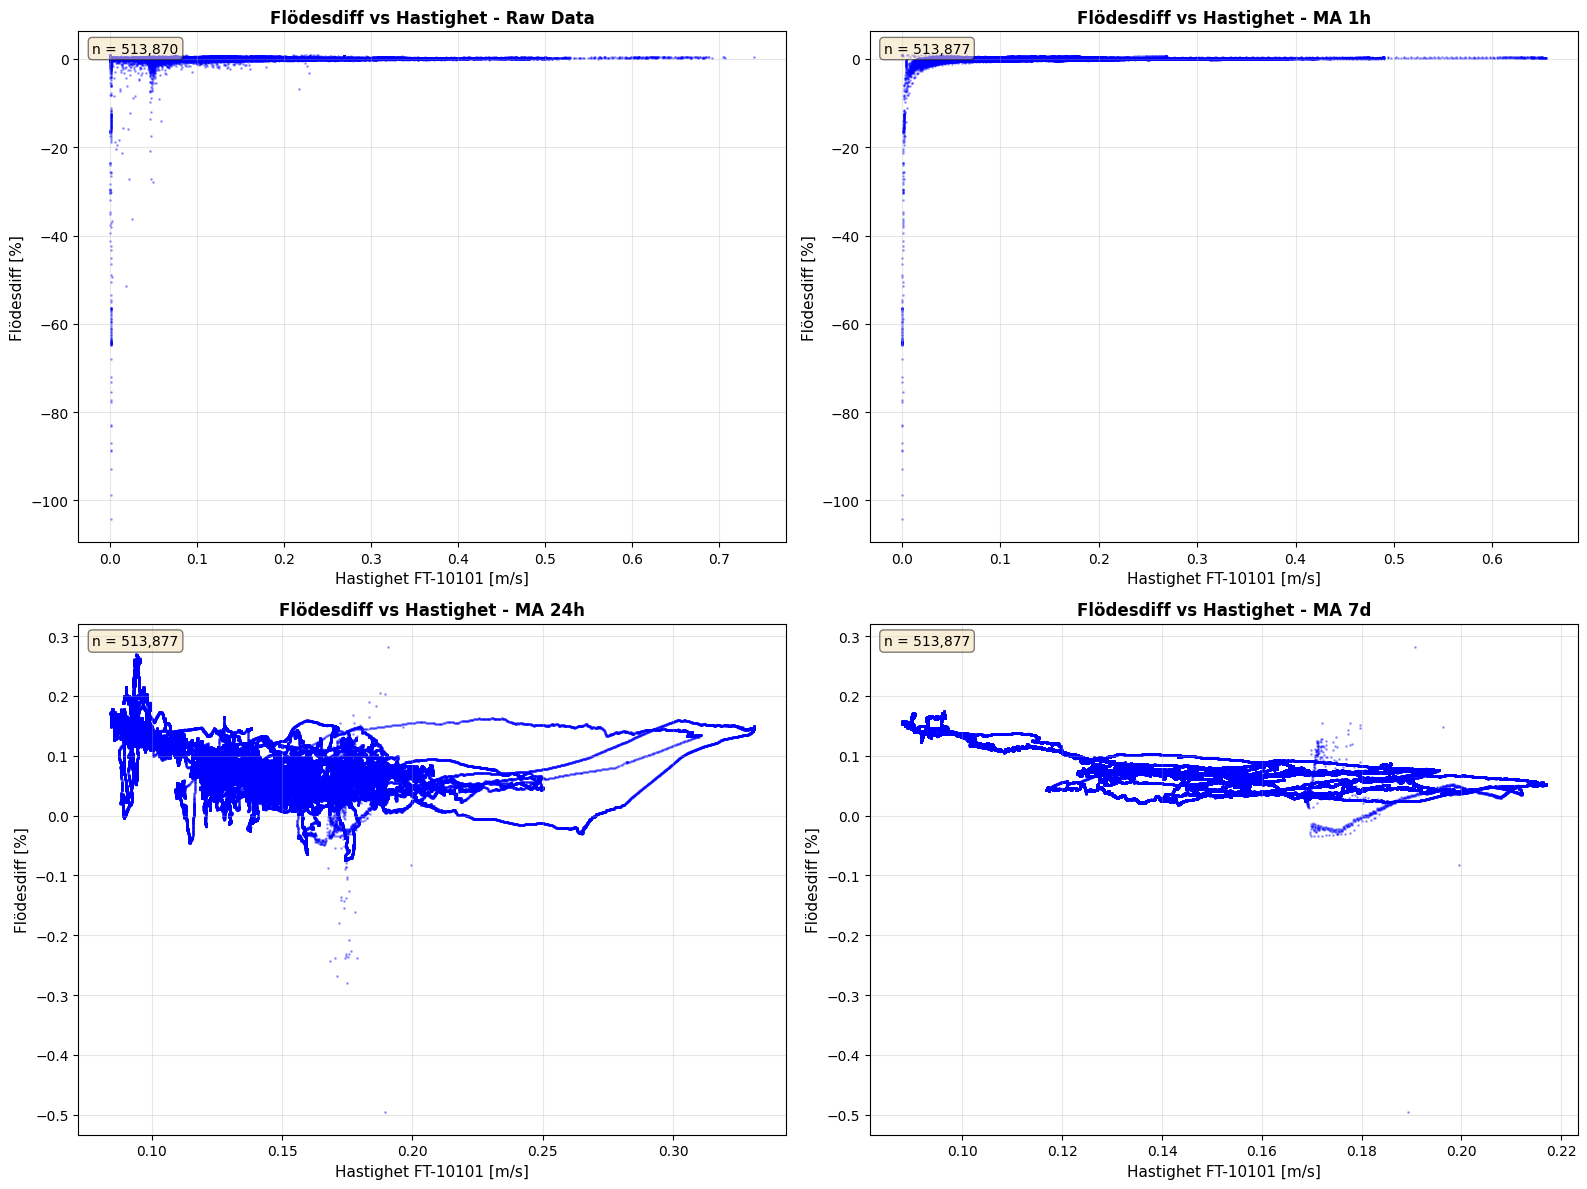

Created 4 scatter plots:
  1. Raw velocity vs Diff_MA_1h
  2. Velocity MA_1h vs Diff_MA_1h
  3. Velocity MA_24h vs Diff_MA_24h
  4. Velocity MA_7d vs Diff_MA_7d


In [55]:
# Create 4 separate XY scatter plots: Velocity (X) vs Flow Difference (Y)
# 1. Raw data (no MA)
# 2. MA_1h vs MA_1h
# 3. MA_24h vs MA_24h
# 4. MA_7d vs MA_7d

import matplotlib.pyplot as plt

# Define the pairs to plot: (velocity_column, flowdiff_column, title_suffix)
plot_pairs = [
    ('Inflöde FT-10101 [m/s]', 'Diff_MA_1h', 'Raw Data'),
    ('Inflöde FT-10101 [m/s]_MA_1h', 'Diff_MA_1h', 'MA 1h'),
    ('Inflöde FT-10101 [m/s]_MA_24h', 'Diff_MA_24h', 'MA 24h'),
    ('Inflöde FT-10101 [m/s]_MA_7d', 'Diff_MA_7d', 'MA 7d')
]

# Create 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, (velocity_col, flowdiff_col, title_suffix) in enumerate(plot_pairs):
    ax = axes[idx]
    dprint(flowdiff_col)
    # Get non-NaN pairs only
    mask = df_velocity_aligned[velocity_col].notna() & df_flowdiff_aligned[flowdiff_col].notna()
    x_data = df_velocity_aligned.loc[mask, velocity_col]
    y_data = df_flowdiff_aligned.loc[mask, flowdiff_col]
    
    # Create scatter plot
    ax.scatter(x_data, y_data, alpha=0.3, s=1, color='blue')
    
    ax.set_xlabel('Hastighet FT-10101 [m/s]', fontsize=11)
    ax.set_ylabel('Flödesdiff [%]', fontsize=11)
    ax.set_title(f'Flödesdiff vs Hastighet - {title_suffix}', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Add data point count
    ax.text(0.02, 0.98, f'n = {mask.sum():,}', 
            transform=ax.transAxes, 
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print("Created 4 scatter plots:")
print("  1. Raw velocity vs Diff_MA_1h")
print("  2. Velocity MA_1h vs Diff_MA_1h")
print("  3. Velocity MA_24h vs Diff_MA_24h")
print("  4. Velocity MA_7d vs Diff_MA_7d")

In [56]:
# Cross-Correlation Analysis
from scipy.signal import correlate
import numpy as np

# Calculate cross-correlation
correlation = correlate(df_ax['Inflöde FT-10101'].fillna(0), 
                        df_ax['Utflöde FT-72101'].fillna(0), 
                        mode='full')

# Find the lag that gives maximum correlation
lags = np.arange(-len(df_ax) + 1, len(df_ax))
optimal_lag_idx = np.argmax(correlation)
optimal_lag = lags[optimal_lag_idx]

print(f"Optimal lag: {optimal_lag} minutes")

Optimal lag: -7 minutes


In [38]:
# Time-Shift the Outlet Data and Calculate Lag-Compensated Flow Balance
# Shift outlet data backward by the lag period
lag_minutes = -7  # Adjust this as needed; 0 should make lag-comp = standard if formulas match

df_ax['Utflöde FT-72101_shifted'] = df_ax['Utflöde FT-72101'].shift(lag_minutes)
df_ax['Inflöde Extenslam FT80101_shifted'] = df_ax['Inflöde Extenslam FT80101'].shift(lag_minutes)
df_ax['Utflöde Bräddning LT23101_shifted'] = df_ax['Utflöde Bräddning LT23101'].shift(lag_minutes)

# Calculate raw lag-compensated flow difference (Method B: ratio then MA applied to ratio)
total_inflow = df_ax['Inflöde FT-10101'] + df_ax['Inflöde Extenslam FT80101_shifted']
total_outflow_shifted = df_ax['Utflöde FT-72101_shifted'] + df_ax['Utflöde Bräddning LT23101_shifted']
raw_denominator = total_inflow.replace(0, pd.NA)
df_flowdiff_lagcomp_raw = (total_inflow - total_outflow_shifted) / raw_denominator
df_flowdiff_lagcomp_raw.name = 'Diff_Lag_Raw'

# Moving averages of the raw lag-compensated ratio (Method B continued)
df_flowdiff_lagcomp_ma_of_raw = pd.DataFrame(index=df_flowdiff_lagcomp_raw.index)
windows_lagcomp = {'1h': '60min', '24h': '24h', '7d': '7D'}
for w_label, w_offset in windows_lagcomp.items():
    ma = df_flowdiff_lagcomp_raw.rolling(w_offset, min_periods=1).mean()
    ma_col_name = f"Diff_Lag_MAofRaw_{w_label}"
    df_flowdiff_lagcomp_ma_of_raw[ma_col_name] = ma

# Method A: Ratio of moving averages (matches original df_flowdiff construction logic)
# Original df_flowdiff computed: (MA(InflowMain)+MA(Externslam) - MA(OutflowMain) - MA(Bräddning)) / (MA(InflowMain)+MA(Externslam))
# Here we reproduce that with the shifted outflow column.
df_flowdiff_lagcomp_ratio_of_mas = pd.DataFrame(index=df_ax.index)
for w_label, w_offset in windows_lagcomp.items():
    inflow_ma = df_ax['Inflöde FT-10101'].rolling(w_offset, min_periods=1).mean()
    externslam_ma = df_ax['Inflöde Extenslam FT80101'].rolling(w_offset, min_periods=1).mean()
    outflow_ma_shifted = df_ax['Utflöde FT-72101_shifted'].rolling(w_offset, min_periods=1).mean()
    braddning_ma = df_ax['Utflöde Bräddning LT23101'].rolling(w_offset, min_periods=1).mean()
    denom = (inflow_ma + externslam_ma)
    denom = denom.where(denom != 0, pd.NA)  # avoid division by zero
    diff_ratio_ma = (inflow_ma + externslam_ma - outflow_ma_shifted - braddning_ma) / denom
    df_flowdiff_lagcomp_ratio_of_mas[f'Diff_Lag_RatioOfMAs_{w_label}'] = diff_ratio_ma

# Combine all lag-comp variants
df_flowdiff_lagcomp_all = pd.concat([
    df_flowdiff_lagcomp_raw,
    df_flowdiff_lagcomp_ma_of_raw,
    df_flowdiff_lagcomp_ratio_of_mas
], axis=1)

# Merge with original flow differences
# NOTE: df_flowdiff already contains Diff_MA_* (ratio-of-MAs) for unshifted case.
df_flowdiff_compensated = pd.merge(df_flowdiff, df_flowdiff_lagcomp_all, left_index=True, right_index=True, how='outer')

print("\nLag-compensated flow differences created:")
print("  Columns:", df_flowdiff_lagcomp_all.columns.tolist())
print("  Shape:", df_flowdiff_lagcomp_all.shape)
print("\nLegend:")
print("  Diff_Lag_Raw                -> Raw lag-compensated instantaneous ratio")
print("  Diff_Lag_MAofRaw_<window>   -> Moving average applied AFTER ratio (Method B)")
print("  Diff_Lag_RatioOfMAs_<window>-> Ratio of moving averages (Method A, comparable to Diff_MA_<window> when lag_minutes=0)")

# Optional sanity check when lag_minutes == 0
if lag_minutes == 0:
    for w in windows_lagcomp.keys():
        col_a = f'Diff_MA_{w}'
        col_b = f'Diff_Lag_RatioOfMAs_{w}'
        if col_a in df_flowdiff.columns and col_b in df_flowdiff_compensated.columns:
            diff_series = (df_flowdiff_compensated[col_a] - df_flowdiff_compensated[col_b]).abs()
            print(f"Window {w}: median abs difference between original and lag-comp RatioOfMAs: {diff_series.median():.6g}")
            print(f"             95th percentile abs difference: {diff_series.quantile(0.95):.6g}")



DataError: No numeric types to aggregate

In [ ]:
print(f"\nLag-compensated flow differences created:")
print(f"  Columns: {df_flowdiff_lagcomp_all.columns.tolist()}")
print(f"  Shape: {df_flowdiff_lagcomp_all.shape}")

if __name__ == "__main__":
    import sys as _sys
    from IPython import get_ipython

    def _make_and_show():
        app = QApplication.instance() or QApplication(_sys.argv)
        
        # Calculate total number of series for settings file key
        n_series_flows = len(df_flows.columns) + len(df_flowdiff.columns)
        settings_key = f'Flöden och Flödesdiff laggkomp ({n_series_flows} series)'
        print(f"Chart settings key: {settings_key}")
        
        mainWin = IPW(df_axL = df_flows,
                            df_axL_Title = 'Flöde & Bräddflöde laggkompensation [m3/h]', 
                            df_axR = df_flowdiff_compensated, 
                            df_axR_Title = 'Flödesdiff [%]',
                            WindowTitle='Pajala ARV Flöde med laggkompensation',
                            settings_file=f'InteractivePlotWindow.json::{settings_key}'
                        )
        mainWin.show()
        # Keep references to avoid garbage collection in notebook kernels.
        
        # Store on the app and module globals so the objects persist after this function returns.
        try:
            app._pajala_mainWin = mainWin
        except Exception:
            pass
        globals()['_pajala_mainWin'] = mainWin
        globals()['_pajala_app'] = app
        return app

    # If running inside an IPython kernel (notebook), request IPython to enable the Qt event loop
    if 'ipykernel' in _sys.modules:
        try:
            ip = get_ipython()
            if ip is not None:
                # enable GUI event loop integration; this avoids a blocking app.exec() call
                ip.run_line_magic('gui', 'qt')
        except Exception:
            ip = None
        # Create and show window but do NOT call app.exec() - the event loop is managed by IPython
        app = _make_and_show()
        # Keep references in the IPython user namespace if available so users can interact with them
        if ip is not None:
            try:
                ip.user_ns['_pajala_app'] = app
                ip.user_ns['_pajala_mainWin'] = globals().get('_pajala_mainWin')
            except Exception:
                # Fall back to module globals (already set by _make_and_show)
                pass
    else:
        # Running as a script: start the blocking event loop
        app = _make_and_show()
        _sys.exit(app.exec())

In [ ]:
# Calculate cumulative volumes
df_cumsumflows = pd.DataFrame(index=df_ax.index)
df_cumsumflows['Inflöde FT-10101_[m3]]'] = df_ax['Inflöde FT-10101'].cumsum()
df_cumsumflows['Inflöde Extenslam FT80101_[m3]'] = df_ax['Inflöde Extenslam FT80101'].cumsum()
df_cumsumflows['Utflöde FT-72101_[m3]'] = df_ax['Utflöde FT-72101'].cumsum()
df_cumsumflows['Utflöde Bräddning LT23101_[m3]'] = df_ax['Utflöde Bräddning LT23101'].cumsum()

df_cumsumflows['Inflow_[m3]'] = (df_ax['Inflöde FT-10101'] + 
                          df_ax['Inflöde Extenslam FT80101']).cumsum()
df_cumsumflows['Outflow_[m3]'] = (df_ax['Utflöde FT-72101'] + 
                           df_ax['Utflöde Bräddning LT23101']).cumsum()

# Storage change = Cumulative inflow - Cumulative outflow
df_cumsumflows['Storage_Change_[m3]'] = df_cumsumflows['Inflow_[m3]'] - df_cumsumflows['Outflow_[m3]']
df_cumsumflows['Storage_Change_Percent'] = df_cumsumflows['Storage_Change_[m3]'] / df_cumsumflows['Inflow_[m3]'] * 100.0
# df_flow_cumsum = pd.merge(df_flows,df_cumsumflows, left_index=True, right_index=True, how='outer'                          )

In [ ]:
from InteractivePlotWindow import InteractivePlotWindow as IPW
from PyQt6.QtWidgets import QApplication

if __name__ == "__main__":
    import sys as _sys
    from IPython import get_ipython

    def _make_and_show():
        app = QApplication.instance() or QApplication(_sys.argv)
        
        # Calculate total number of series for settings file key
        n_series_flows = len(df_flows.columns) + len(df_flowdiff.columns)
        settings_key = f'Kumsumflöden in och ut ({n_series_flows} series)'
        print(f"Chart settings key: {settings_key}")
        
        mainWin = IPW(df_axL = df_flows,
                            df_axL_Title = 'Flöde [m3/h]', 
                            df_axR = df_cumsumflows, 
                            df_axR_Title = 'Kumsumflöde [m3]',
                            WindowTitle='Pajala ARV Flödesn och kumsumflöden',
                            settings_file=f'InteractivePlotWindow.json::{settings_key}'
                        )
        mainWin.show()
        # Keep references to avoid garbage collection in notebook kernels.
        
        # Store on the app and module globals so the objects persist after this function returns.
        try:
            app._pajala_mainWin = mainWin
        except Exception:
            pass
        globals()['_pajala_mainWin'] = mainWin
        globals()['_pajala_app'] = app
        return app

    # If running inside an IPython kernel (notebook), request IPython to enable the Qt event loop
    if 'ipykernel' in _sys.modules:
        try:
            ip = get_ipython()
            if ip is not None:
                # enable GUI event loop integration; this avoids a blocking app.exec() call
                ip.run_line_magic('gui', 'qt')
        except Exception:
            ip = None
        # Create and show window but do NOT call app.exec() - the event loop is managed by IPython
        app = _make_and_show()
        # Keep references in the IPython user namespace if available so users can interact with them
        if ip is not None:
            try:
                ip.user_ns['_pajala_app'] = app
                ip.user_ns['_pajala_mainWin'] = globals().get('_pajala_mainWin')
            except Exception:
                # Fall back to module globals (already set by _make_and_show)
                pass
    else:
        # Running as a script: start the blocking event loop
        app = _make_and_show()
        _sys.exit(app.exec())